In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
import librosa
import librosa.display
import IPython.display
import json
import os

from src.data import NSynth, Freesound, create_audio_transform, load_audio, Normalize
from src.models import Autoencoder

In [2]:
model_dir = 'train_results/autoencoder/20200723-231955'

hparams = json.load(open(os.path.join(model_dir, 'hparams.json'), 'rb'))

weights_path = sorted([x for x in os.listdir(model_dir) if 'model' in x], key=lambda x : int(x.split('-')[-1].split('.')[0]))[-1]
weights_path = os.path.join(model_dir, weights_path)
print(weights_path)

train_results/autoencoder/20200723-231955/model-186186.weights


In [3]:
model = Autoencoder(h_dim=hparams['hidden_dim'], sigmoid=(not hparams['standardize']))
model.load_state_dict(torch.load(weights_path))
model.eval()

Autoencoder(
  (encode): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 4), stride=(2, 2), padding=(1, 4))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stri

In [4]:
transform = create_audio_transform(
    hparams['sample_rate'],
    n_samples=hparams['n_samples'],
    random_crop=False,
    feature_type=hparams['feature_type'],
    resize=hparams['resize'],
    normalize=hparams['normalize'],
    standardize=hparams['standardize'],
    standardize_mean=hparams['standardize_mean'],
    standardize_std=hparams['standardize_std'],
    spec_augment=False
)

In [36]:
freesound.meta.head(20)

,fname,label,usage,freesound_id,license
0,data/freesound/FSDKaggle2018.audio_test/00326a...,Oboe,Private,355125,Attribution
1,data/freesound/FSDKaggle2018.audio_test/0038a0...,Bass_drum,Private,90621,Creative Commons 0
2,data/freesound/FSDKaggle2018.audio_test/007759...,Saxophone,Private,13406,Creative Commons 0
3,data/freesound/FSDKaggle2018.audio_test/008afd...,Saxophone,Private,358962,Attribution
4,data/freesound/FSDKaggle2018.audio_test/00ae03...,Chime,Private,78203,Attribution
5,data/freesound/FSDKaggle2018.audio_test/00eac3...,Electric_piano,Public,371494,Creative Commons 0
6,data/freesound/FSDKaggle2018.audio_test/010a0b...,Shatter,Private,368342,Attribution
7,data/freesound/FSDKaggle2018.audio_test/01a5a2...,Bark,Private,30344,Attribution
8,data/freesound/FSDKaggle2018.audio_test/01bb34...,Acoustic_guitar,Private,128810,Attribution
9,data/freesound/FSDKaggle2018.audio_test/021070...,Electric_piano,Private,65660,Attribution


In [23]:
nsynth = NSynth('data/nsynth', 'test')
freesound = Freesound('data/freesound', 'test')

In [101]:
audio = load_audio(nsynth.files[10], sample_rate=hparams['sample_rate'])
#audio = load_audio(freesound.meta.iloc[5]['fname'], sample_rate=hparams['sample_rate'])

In [102]:
features = transform(audio)
norm = [x for x in transform.transforms if type(x) == Normalize][0]

In [103]:
with torch.no_grad():
    features = features.unsqueeze(0)
    outputs = model(features)

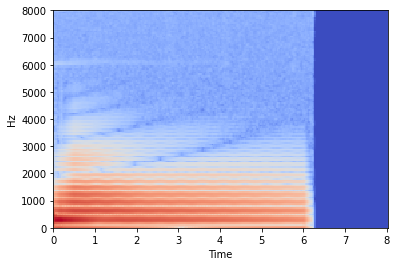

In [104]:
librosa.display.specshow(features.numpy().squeeze(), sr=16000, x_axis='time', y_axis='hz')

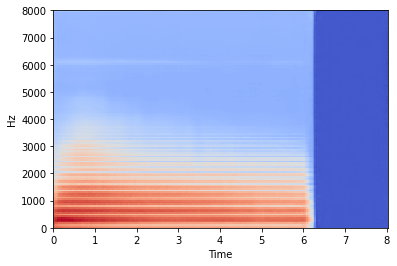

In [105]:
librosa.display.specshow(outputs.detach().numpy().squeeze(), sr=16000, x_axis='time', y_axis='hz')

In [106]:
reconstruction = (outputs * hparams['standardize_std']) + hparams['standardize_mean']
reconstruction = (reconstruction * (norm.max - norm.min)) + norm.min
reconstruction = librosa.db_to_power(reconstruction.numpy().squeeze())

sample = librosa.feature.inverse.mel_to_audio(
    reconstruction, sr=hparams['sample_rate'], n_fft=1024, hop_length=256, norm=None, htk=True
)

#### Original

In [107]:
IPython.display.Audio(audio, rate=hparams['sample_rate'])

#### Reconstructed

In [108]:
IPython.display.Audio(sample, rate=hparams['sample_rate'])